<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/RandomForest_SMOTE_SMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings
import ast

import lightgbm as lgb
import xgboost as xgb

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline


################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Load Spell Check ###################
# Load word2vec model pre-trained on Google News corpus (3 billion running words) 
"""
t0 = time.time()
google = api.load('word2vec-google-news-300')

words = google.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

print("Time taken to load SpellChecker: {}m".format(round((time.time()-t0)/60,2)))
"""
################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc,use_stop=True):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', r' ', doc)
    # 4) Remove extra whitespaces
    doc = re.sub(r"\s+",r" ",doc)
    # 5) Remove leading/trailing whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    if use_stop:
      # filter stopwords out of document
      filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
      filtered_tokens = tokens
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Old-school lemmatization
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-']         

# Spell-check, then lemmatize
def spell_and_lemmatize(doc):
    # 1) Replace contraction patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 2) Remove special characters, replace newlines with spaces, remove extra spaces
    doc = re.sub(r'[^a-zA-Z\s]+', ' ', doc)
    doc = re.sub(r'[\n\r\t\r\n]',r' ',doc,re.I|re.U)
    doc = re.sub(r"\s+",r" ",doc)
    # 3) Remove leading and trailing whitespaces
    doc = doc.strip()
    # 4) Filter only verbs, nouns, adjectives, and adverbs. Remove stopwords.
    filtered = [token.text for token in spacy_nlp(doc) if token.pos_ in ['VERB','NOUN','ADJ','ADV','PROPN'] and token.text.lower() not in stop_words]
    # 5) Spell-check words that are not proper nouns
    corrected = [correction(token.text) if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(filtered))]
    # 6) Apply lemmatization to spell-checked words
    lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(corrected))]
    # 7) Remove pronouns, convert to lowercase
    final_lemmas = [token.text.lower() for token in spacy_nlp(" ".join(lemmas)) if token.lemma_ != '-PRON-']
    return final_lemmas

## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [spell_and_lemmatize(x) for x in train['comment_text']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed_str'].to_csv('train_clean_lemmed.csv',sep=',',index=False)

## Read from csv
train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)

## Transform cleaned/lemmed strings
train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: str(x))
#train['clean_lemmed_list'] = train['clean_lemmed'].apply(lambda x: x.split())
train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
################### Feature Engineering ###################

# TF-IDF Vectorizer
train_text = train['clean_lemmed_str']

word_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    #smooth_idf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)

char_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(train_text)
train_char_features = char_vectorizer.transform(train_text)

tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
#train_tfidf_features = train_word_features.tocsr()

# Create features about type of text and category of text
def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[\.\!\?\=\+\#\*\|\~\-\,]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy][oO][uU]\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_shit"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss][Hh][Ii][Tt]", x))
    df["nb_kill"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[kK][iI][lL][lL]", x))
    df["nb_die"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[dD][iI][eE]\s", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][iI][cC][kK]", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][oO][cC][kK]", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_piss"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][iI][sS][sS]", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_retard"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[rR][eE][tT][aA][rR][dD]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_idiot"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[iI][dD][iI][oO][tT]", x))
    df["nb_stupid"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][tT][uU][pP][iI][dD]", x))
    df["nb_dumb"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][uU][mM][bB]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[mM][oO][tT][hH][eE][rR](\W|\s|$)", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[nN][iI][gG][gG][eE][rR](\W|\s|$)", x))
    df["nb_fat"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[Ff][aA][tT](\W|\s|$)", x))
    df["nb_ass"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"((\W|\s|$)[aA][sS][sS]\w)|(\w[aA][sS][sS](\W|\s|$))", x))
    df["nb_fg"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[fF][aA][gG][gG][oO][tT]", x))
    df["nb_fg_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[fF][aA][gG](\W|\s|$)", x))
    df["nb_cancer"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][aA][nN][cC][eE][rR]", x))
    return

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    return
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))
    return

## Create features
add_features(train)
pos_tagging(train)
pos_features(train)

## Look for duplicate comments
"""
Defining duplicate as: any time a comment appears more than twice.
"""
comment_counts = train['clean_comments'].value_counts().to_dict()
train['is_duplicate'] = train['clean_comments'].apply(lambda x: int(comment_counts[x]>1))
#print(train.loc[train['is_duplicate']==1,class_names].sum(axis=0))

## Look for spam comments
"""
Defining spam as: any comment that has the same sentence repeated twice.
"""
train['comment_list'] = train['comment_text'].apply(lambda x: (clean_document(x,use_stop=True)).split())

def count_duplicates(seq): 
    '''
    takes as argument a sequence and returns the number of duplicate elements
    ex: count_duplicates(["hello world.","hello world.","hello world."]) -> 2
    ex: count_duplicates(["hello world","fuck disneyland","hello world"]) -> 1
    '''
    return len(seq) - len(set(seq))

def count_non_duplicates(seq):
  '''
  takes as argument a list of words, and returns the percentage of words that are duplicates
  '''
  if len(set(seq)) == 0: return 0
  count_dict = Counter(seq)
  dup_words = [word for (word,count) in count_dict.items() if count >= 2]
  return len(dup_words)/len(set(seq))
  
train['is_spam'] = train['comment_list'].apply(lambda x: int(count_non_duplicates(x)>=0.5))
#print(train.loc[train['is_spam']==1,class_names].sum(axis=0))

meta_features = train.drop(['id','comment_text','clean_comments','clean_comments_list','clean_lemmed','clean_lemmed_str','clean_lemmed_list','comment_raw','POS','sentence_list','repeated_sentences','comment_list']+class_names,axis=1,inplace=False,errors='ignore')
train_features = hstack([sparse.csr_matrix(meta_features.values), tfidf_features]).tocsr()

In [0]:
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'binary_error',
    'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1
}

xgb_params = {
    "objective": "binary:logistic",
    'eval_metric': 'map',
    "booster": "gbtree",
    "verbosity": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "learning_rate": 0.1,
    "lambda":1,
    "num_leaves": 31
}

Best Threshold=0.251440, F-Score=0.472
Best Threshold=0.200090, F-Score=0.503
Best Threshold=0.207257, F-Score=0.525
Best Threshold=0.190769, F-Score=0.505
Best Threshold=0.186424, F-Score=0.508
Class:  severe_toxic  | mean AUC:  0.9868
Avg best threshold:  0.2072


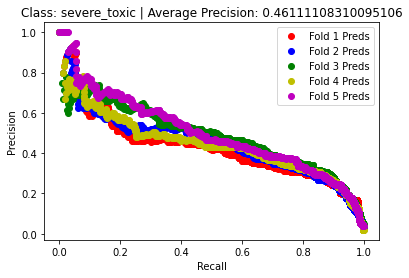

In [6]:
##### Investigating class imbalance + improving recall #####
resp = 'severe_toxic'
training_labels = train[resp]
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
use_lgb=False
use_smote = False

## Over_sampling and under_sampling
#over_ratios = [0.05,0.1,0.2]
under_ratios = [0.025,0.05,0.1,0.15]

#for ratio in under_ratios:
# Define new re-sampled data
class_pred = np.zeros(train_features.shape[0])
# Use 5-fold cross-validation to evaluate performance at given over-sampling ratio.
auc,precision,recall,thresholds,f_scores,best_t = [],[],[],[],[],[]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  if use_smote:
    # Define pipeline to oversample, undersample, and then cross-validate
    #over = SMOTE(sampling_strategy=0.025,k_neighbors=10)
    under = TomekLinks(sampling_strategy='majority')
    #under = RandomUnderSampler(sampling_strategy=ratio)
    #steps = [('over', over), ('under', under), ('model', model)]
    #pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    X_re, y_re = under.fit_resample(train_features[trn_idx],training_labels[trn_idx])
    #X_re, y_re = under.fit_resample(X_re,y_re)   
    X_train = X_re
    y_train = y_re
  else:
    X_train =  train_features[trn_idx]
    y_train = training_labels[trn_idx]
  if use_lgb:
    trn_lgbset = lgb.Dataset(X_train, free_raw_data=False)
    trn_lgbset.set_label(y_train)
    lgb_rounds = 500
    #weight_ratio = np.sum(training_labels[trn_idx] == 0) / np.sum(training_labels[trn_idx] == 1)
    #lgb_params['scale_pos_weight'] = weight_ratio
    model = lgb.train(params=lgb_params,
                      train_set=trn_lgbset, 
                      num_boost_round=lgb_rounds,
                      valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                      early_stopping_rounds=50,
                      verbose_eval=0)
    class_pred[val_idx] = model.predict(train_features[val_idx], num_iteration=model.best_iteration)
  else:
    dtrain = xgb.DMatrix(X_train,label=y_train) 
    dval =  xgb.DMatrix(train_features[val_idx],label=training_labels[val_idx]) 
    watchlist = [(dtrain,'train'), (dval, 'valid')]
    xgb_rounds=200
    #weight_ratio = np.sum(X_re == 0) / np.sum(y_re == 1)
    #print("Weight ratio: ",weight_ratio)
    #xgb_params['scale_pos_weight'] = weight_ratio 
    model = xgb.train(params=xgb_params,
                      dtrain=dtrain,
                      num_boost_round=xgb_rounds,
                      evals=watchlist,
                      early_stopping_rounds=50,
                      verbose_eval=False)
    class_pred[val_idx] = model.predict(xgb.DMatrix(train_features[val_idx]), ntree_limit = model.best_ntree_limit)
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)
  # Find optimal threshold
  fscore = (2 * prec * recal) / (prec + recal)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Fold ', n_fold, ':','Best Threshold=%f, F-Score=%.3f' % (thresh[ix], fscore[ix]))
  best_t.append(thresh[ix])
  f_scores.append(fscore[ix])

# Print out mean AUC score
print("Class: ",resp,' | mean AUC: ',str(round(np.mean(auc),4)))
print("Class: ",resp,' | mean F-Score: ',str(round(np.mean(f_scores),4)))
print("Avg best threshold: ",str(round(np.mean(best_t),4)))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()


In [0]:
##### Extract comments that were mislabelled #####
dtrain = xgb.DMatrix(X_train,label=y_train) 
    dval =  xgb.DMatrix(train_features[val_idx],label=training_labels[val_idx]) 
    watchlist = [(dtrain,'train'), (dval, 'valid')]
    xgb_rounds=200
    #weight_ratio = np.sum(X_re == 0) / np.sum(y_re == 1)
    #print("Weight ratio: ",weight_ratio)
    #xgb_params['scale_pos_weight'] = weight_ratio 
    model = xgb.train(params=xgb_params,
                      dtrain=dtrain,
                      num_boost_round=xgb_rounds,
                      evals=watchlist,
                      early_stopping_rounds=50,
                      verbose_eval=False)
    class_pred[val_idx] = model.predict(xgb.DMatrix(train_features[val_idx]), ntree_limit = model.best_ntree_limit)
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)
  # Find optimal threshold
  fscore = (2 * prec * recal) / (prec + recal)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Fold ', n_fold, ':','Best Threshold=%f, F-Score=%.3f' % (thresh[ix], fscore[ix]))
  best_t.append(thresh[ix])
  f_scores.append(fscore[ix])




In [11]:
##### Bayesian Hyperparameter Tuning for LightGBM/XGBoost #####

warnings.filterwarnings("ignore")

# Define variables for CV
#class_names = ['severe_toxic', 'threat', 'identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
class_pred = np.zeros(train_features.shape[0])
auc,precision,recall,thresholds = [],[],[],[]
use_lgb = False

# Define response class
resp = 'severe_toxic'
training_labels = train[resp]

### Define functions for Bayesian Hyperparameter Optimization (SMBO using TPE)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, make_scorer

# 1) Define objective 

def objective(params):
    time1 = time.time()
    if use_lgb:
      params = {
          'learning_rate': params['learning_rate'],
          'bagging_fraction': params['bagging_fraction'],
          'feature_fraction': params['feature_fraction']}
    else:
        params = {
          'learning_rate': params['learning_rate'],
          'subsample': params['bagging_fraction'],
          'colsample_bytree': params['feature_fraction']}
    print("\n############## New Run ################")
    print(f"params = {params}")
    score_mean = 0
    class_pred = np.zeros(train_features.shape[0])

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      if use_lgb:
        trn_lgbset = lgb.Dataset(train_features[trn_idx], free_raw_data=False)
        trn_lgbset.set_label(training_labels[trn_idx])
        clf = lgb.train(params=params,
                        train_set=trn_lgbset, 
                        num_boost_round=lgb_rounds,
                        valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                        early_stopping_rounds=50,
                        verbose_eval=0)
        class_pred[val_idx] = clf.predict(train_features[val_idx], num_iteration=clf.best_iteration)
      else:
        dtrain = xgb.DMatrix(train_features[trn_idx],label=training_labels[trn_idx]) 
        dval =  xgb.DMatrix(train_features[val_idx],label=training_labels[val_idx]) 
        watchlist = [(dtrain,'train'), (dval, 'valid')]
        xgb_rounds=100 
        clf = xgb.train(params=params,
                          dtrain=dtrain,
                          num_boost_round=xgb_rounds,
                          evals=watchlist,
                          early_stopping_rounds=50,
                          verbose_eval=False)
        class_pred[val_idx] = clf.predict(xgb.DMatrix(train_features[val_idx]), ntree_limit = clf.best_ntree_limit)

      score = average_precision_score(training_labels[val_idx],class_pred[val_idx],average='weighted')
      score_mean += score
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    #gc.collect()
    print(f'Average Precision Score: {score_mean/splits}')
    return (score_mean / splits)


# 2) Define search space

space = {    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    #'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # Learning rate: Rate at which trees learn from error of previous models
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # feature_fraction: Controls the subsampling of features used. Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    
    # bagging_fraction and bagging_freq: Enables bagging (subsampling) of the training data.  Smaller fractions and frequencies reduce overfitting.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1)
    
}

# 3) Specify Optimization algorithm
tpe_algo = tpe.suggest

# 4) Instantiate Trials object to track results
tpe_trials = Trials()

# Set hyperopt parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe_algo,
            trials = tpe_trials,
            

            max_evals=100)
# Print best parameters
best_params = space_eval(space, best)
print("BEST PARAMS: ", best_params)



############## New Run ################
params = {'learning_rate': 0.09771042464864453, 'subsample': 0.500264062121279, 'colsample_bytree': 0.7204083200781088}
  0%|          | 0/100 [00:22<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

In [0]:
# Set LGBM parameters
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'map',
    #'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    'learning_rate': params['learning_rate'],
    'bagging_fraction': params['bagging_fraction'],
    'feature_fraction': params['feature_fraction'],
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1
}

xgb_params = {
    "objective": "binary:logistic",
    'eval_metric': 'map',
    "booster": "gbtree",
    "verbosity": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "learning_rate": 0.1,
    "lambda":1,
    "num_leaves": 31
}

# Make predictions for each fold in split, calculate evaluation metrics
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  # Train Hyperoptimized LightGBM
  trn_lgbset = lgb.Dataset(train_features[trn_idx], free_raw_data=False)
  trn_lgbset.set_label(training_labels[trn_idx])
  model = lgb.train(params=params,
                    train_set=trn_lgbset, 
                    num_boost_round=lgb_rounds,
                    valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                    early_stopping_rounds=50,
                    verbose_eval=0)
  class_pred[val_idx] = model.predict(train_features[val_idx], num_iteration=model.best_iteration)
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)

# Print out mean AUC score
print("class: ",resp,' | mean AUC: ',str(round(np.mean(auc),4)))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()